<a href="https://colab.research.google.com/github/mathewvarghesemanu/3D_print_cost_calculator_flutter/blob/main/creating_video_from_tSNE_plot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We will look at creating a video based on tSNE embeddings of images.

In [ ]:
# Mounting Google Drive
from google.colab import drive
drive.mount('./gdrive/')

Drive already mounted at ./gdrive/; to attempt to forcibly remount, call drive.mount("./gdrive/", force_remount=True).


## -1. Create a video from images
Download any 1000 or more 'appropriate' and publicly available images from the web. This could be part of a data set or something specific that you picked up or are interested in.

Apply the tSNE library to these images and construct low-dimensional embeddings for the images. Use these embeddings to then:

a) Start at any random image in the data set 

b) Sequentially chain the next image to the previous image using a scoring function/probability based on the tSNE embedding. So you want to chain the most similar image to the current one and so on. Choose a frame rate that is appropriate to convert this chain of images into a video. Your video shouldn't be more than 3 minutes long.



In [ ]:
# unzipping files. There is an option to choose multiple databases here.
!unzip -q -o "/content/gdrive/MyDrive/datasets/Face_Dataset/face_dataset.zip"
# !unzip -q -o "/content/gdrive/MyDrive/datasets/Iris/flower_test-1.zip"
# !unzip -q -o "/content/gdrive/MyDrive/datasets/mnist/archive.zip"


In [ ]:
# source for face data set : https://github.com/NVlabs/ffhq-dataset

In [ ]:
# imports
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import ndimage, misc

# choosing the image folder
image_folder="/content/69000"
# image_folder="/content/flower_test/daisy"
# image_folder="/content/testSet/testSet"

# function to load images from the folder and return an array of images and an array of the file list
def load_images_from_folder(folder):
    images = []
    file_list=[]
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        file_list.append(os.path.join(folder,filename))
        if len(file_list)>1000:
            break
        img = cv2.resize(img, (128, 128)) 
        # img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        if img is not None:
            images.append(img)
    return (np.array(images),file_list)

# calling the function to receive array of images and array of file list
(images,file_list)=load_images_from_folder(image_folder)
images=np.array(images)

In [ ]:
# Flattening the images in order to make it as a vector
new_images=images.reshape(len(images),-1)
new_images.shape

(1000, 49152)

In [ ]:
# applying PCA with two n components
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
new_images_pca=pca.fit_transform(new_images) 
new_images_pca=new_images

In [ ]:
# Using TNSE
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, learning_rate='auto',init='random').fit_transform(new_images_pca)
X_embedded

array([[  1.9086075,   2.9083486],
       [  3.8320444,  18.54683  ],
       [  9.185232 ,  -6.9704003],
       ...,
       [ 14.549579 ,  11.325017 ],
       [  8.65042  , -10.568511 ],
       [ -7.620551 ,  11.299672 ]], dtype=float32)

In [ ]:
# plotting TNSE
# scale and move the coordinates so they fit [0; 1] range
def scale_to_01_range(x):
    # compute the distribution range
    value_range = (np.max(x) - np.min(x))

    # move the distribution so that it starts from zero
    # by extracting the minimal value from all its values
    starts_from_zero = x - np.min(x)

    # make the distribution fit [0; 1] by dividing by its range
    return starts_from_zero / value_range

# extract x and y coordinates representing the positions of the images on T-SNE plot
tx = X_embedded[:, 0]
ty = X_embedded[:, 1]

tx = scale_to_01_range(tx)
ty = scale_to_01_range(ty)

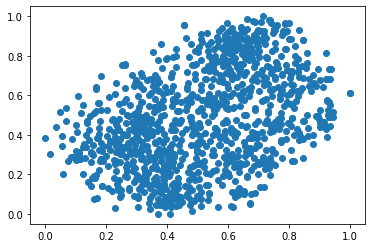

In [ ]:
# scatter plot for TNSE
plt.scatter(tx,ty)

In [ ]:
# Shape of the embedding that is received from the TNSE
X_embedded.shape

(1000, 2)

In [ ]:
# Saving a copy of the file list and the embeddings for convenience
file_list_old=file_list
X_embedded_old=X_embedded

In [ ]:
# Going through the images and finding the least distance between the images. Depending upon that, we append the next image to the image list and the next file to the file list
X_embedded=X_embedded_old
file_list=file_list_old
# assigning X&Y
x_new=X_embedded[0][0]
y_new=X_embedded[0][1]
# appending random element of the file list as the first file path for the final image
file_list_ordered = []
file_list_ordered.append(np.random.randint(0,len(file_list)))
while True:
   distance_matrix = {}
#    finding distance between the current image and all other images
   for i, j in enumerate(X_embedded):
     dis = (j[0] - x_new)**2 + (j[1] - y_new)**2
     distance_matrix[i] = dis
#  sorting the distance between all the images in order for finding the minimum
   sorted_list = sorted(distance_matrix.items(), key=lambda x: x[1])
   temp=sorted_list[0][0]
   file_list_ordered.append(file_list[temp])
   x_new, y_new = X_embedded[temp][0], X_embedded[temp][1]
#    Removing the images from the file list and the embedded list so that we don't traverse through the same images again
   X_embedded = np.delete(X_embedded, temp, 0)
   file_list.remove(file_list[temp])
#    we exit out of the loop when all the vectors in the embedded space are traversed through
   if X_embedded.size == 0:
     break

In [ ]:
# Creating a list of images based on the final file list
img_final_list=[]
for item in file_list_ordered:
    img_final_list.append(cv2.imread(item))
len(img_final_list)

1001

In [ ]:
# Writing the images from the final file list into a video
out = cv2.VideoWriter('project.avi',cv2.VideoWriter_fourcc(*'DIVX'), 15, (128,128))
for item in img_final_list:
    out.write(item)
out.release()

In [ ]:
# https://youtu.be/iDXXj3beCQc
# please find the video on the link above. I have made video based on MNIST and faces data set, and stitched together in post processing. The text on the video (tSNE) is also added later